# Instance segmentation of plastic cups in a video

This notebook demonstrates the task of instance segmentation in one video (on all frames), in this case segmentation of a plastic cup that is transported through the water column. The segmentation is based on creating a mask with a blue-color filter. In this project there is no .. for distortion related to the camera lens. The arucos are not used with their accompanying x,y,z coordinates, but just as markers in a local coordinate system in a x,y space (2D). 

General information: 

<br>

| Model | Storage (datasets + model) | Environment |
| ----- | ---- | ---- |
| HSV filter in OpenCV | P-drive | Locally on your own computer

<br>

The notebook follows these steps:

1. General setup
2. Settings
3. Pre-processing 
4. Creating and tailoring the segmentation routine
5. Using the tailored segmentation routine 

# 1. General setup

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import cv2.aruco as aruco
import imutils
import pandas as pd
import time
import collections

# Enabling interactive Matplotlib widgets to be used to tailor the segmentation routine
%matplotlib widget

# 2. Settings

Full path to the video

In [2]:
pathVideo = os.path.join("..", "..", "data", "segmentation", "CAM01_20231211_13-21-52_clipped.mp4")

Settings to tailor the segmentation routine

In [24]:
# Define Area of Interest (AOI) and the HSV range for the segmentation
starting_frame_tailor = 200  # Frame at which the segmentation is tailored
AOI_1 = [120, 2600, 100, 2130]  # [y1,y2,x1,x2]
HSV_range = [[100, 100, 100], [120, 255, 255]]  # [lower, upper]

Settings used in the segmentation routine, can be left as is

In [25]:
# Define the frame at which the processing (segmentation routine) should start
starting_frame_use = 0

# Define frame synchronization ID and detection parameters
FrameIDSync = starting_frame_use  # Set the initial frame ID for synchronization
DTskip = 5  # Number of frames to skip if the particle is not detected
MemoryDetection = collections.deque(maxlen=30)  # Memory for particle detection in the last 30 frames

# Output directory for the processed frames
dir_output = os.path.join("..", "..", "data", "segmentation", "output")

# 3. Pre-processing

In [26]:
# Open the video file
cap = cv2.VideoCapture(pathVideo)

# Get and print the total frame count and FPS
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
print("FrameCount:", int(frame_count), "\nFrames per second:", int(fps))

FrameCount: 374 
Frames per second: 20


#### 3.1 Create an Area of Interest (AOI) mask

To omit certain parts of the frame (in this case the blue bottom of the frame). This AOI can be different for each video, so it was defined manually in Settings.

In [27]:
# Read the first frame from the video
ret, frame = cap.read()

# Get the height and width of the frame
h, w = frame.shape[:2]

# Check if the video is recorded in portrait mode
rotate = False
if h < w:
    rotate = True
    # Rotate the frame 90 degrees clockwise
    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    # Update the height and width after rotation
    h, w = frame.shape[:2]

# Create an AOI mask
AOI = np.zeros(frame.shape[:2])
AOI[AOI_1[0] : AOI_1[1], AOI_1[2] : AOI_1[3]] = 1
AOI = AOI.astype(np.uint8)

#### 3.2 Calibration of the camera 

Function to detect and annotate ARUCO markers in a given frame


In [28]:
def PlotCalibration(frame_gray, frame_display):
    global aruco_dic, parameters_aruco
    # Detect ARUCO markers in the grayscale frame
    corners, ids, rejectedImgPoints = aruco.detectMarkers(frame_gray, aruco_dict, parameters=parameters_aruco)
    ids_f = []
    corners_f = []
    # Iterate through detected marker IDs
    for i, id_i in enumerate(ids):
        if id_i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]:  # Center of the ARUCO markers
            pts = corners[i].astype(int).reshape((-1, 1, 2))
            # Draw a circle at the center of the marker
            cv2.circle(frame_display, tuple(pts.mean(axis=0)[0].astype(int)), 1, (0, 255, 0), 2)
            # Annotate the marker ID
            cv2.putText(
                frame_display,
                f"Id_{id_i}",
                (pts[0, 0][0], pts[0, 0][1]),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 255, 0),
                2,
                cv2.LINE_AA,
            )
            ids_f.append(id_i)
            corners_f.append(corners[i])
    return

The function uses the ARUCO dictionary and parameters defined to detect markers and draw circles and text annotations on the detected markers. 

In [29]:
# ARUCO parameterization (define ARUCO dictionary and parameters)
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_1000)  # Loading ARUCO fiduciary marker dictionary (4x4 code)

# Initialize ARUCO detector parameters (equal for each video)
parameters_aruco = aruco.DetectorParameters()
parameters_aruco.adaptiveThreshWinSizeMin = 100  # Minimum window size for adaptive thresholding
parameters_aruco.adaptiveThreshWinSizeMax = 300  # Maximum window size for adaptive thresholding
parameters_aruco.adaptiveThreshConstant = 5  # Constant subtracted from mean or weighted mean
parameters_aruco.minMarkerPerimeterRate = 0.03  # Minimum perimeter rate of marker
parameters_aruco.maxMarkerPerimeterRate = 4.0  # Maximum perimeter rate of marker
parameters_aruco.polygonalApproxAccuracyRate = 0.03  # Polygonal approximation accuracy rate
parameters_aruco.minCornerDistanceRate = 0.1  # Minimum distance between corners
parameters_aruco.minDistanceToBorder = 3  # Minimum distance to image border
parameters_aruco.minMarkerDistanceRate = 0.1  # Minimum distance between markers
parameters_aruco.cornerRefinementMethod = aruco.CORNER_REFINE_SUBPIX  # Corner refinement method
parameters_aruco.cornerRefinementWinSize = 5  # Window size for corner refinement
parameters_aruco.cornerRefinementMaxIterations = 30  # Maximum iterations for corner refinement
parameters_aruco.cornerRefinementMinAccuracy = 0.1  # Minimum accuracy for corner refinement
parameters_aruco.markerBorderBits = 1  # Number of bits in marker borders
parameters_aruco.perspectiveRemovePixelPerCell = 8  # Perspective removal pixel per cell
parameters_aruco.perspectiveRemoveIgnoredMarginPerCell = 0.13  # Perspective removal ignored margin per cell
parameters_aruco.maxErroneousBitsInBorderRate = 0.35  # Maximum erroneous bits in border rate
parameters_aruco.errorCorrectionRate = 0.6  # Error correction rate

# 3. Tailor segmentation routine 

Pre-process the video and detect the ARUCO markers

In [30]:
# Set video frame position
cap.set(cv2.CAP_PROP_POS_FRAMES, starting_frame_tailor)  # Set the video position to the 1490th frame (index base 0)
ret, frame = cap.read()  # Read the frame at the specified position

# Rotate the frame 90 degrees clockwise if needed
if rotate:
    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)  # Rotate the frame 90 degrees clockwise if needed

# Prepare the frame for processing
frame_display = frame
frame_HSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)  # Convert the frame to HSV color space
frame_GRAY = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert the frame to grayscale

# Detect and annotate ARUCO markers
PlotCalibration(frame_GRAY, frame_display)

Detect blue objects in the frames and draw its contours and area 

In [31]:
# Color substraction to detect blue objects
fgMask = cv2.inRange(frame_HSV, np.array(HSV_range[0]), np.array(HSV_range[1]))
fgMask = cv2.blur(fgMask, (5, 5), 0)

# Apply AOI mask
fgMask = cv2.bitwise_and(fgMask, fgMask, mask=AOI)

# Detect Main Blob that is filtered with the color substraction
contours_Background, _ = cv2.findContours(fgMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
if len(contours_Background) > 0:
    for i, contour in enumerate(contours_Background):
        ((x, y), radius) = cv2.minEnclosingCircle(contour)
        area = cv2.contourArea(contour)
        try:
            M = cv2.moments(contour)
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
            # Print the area and the radius of the blob
            cv2.putText(
                frame_display,
                f"{area}_{radius}",
                (center[0] + 5, center[1] + 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 255, 0),
                2,
                cv2.LINE_AA,
            )
            ObjectDetected = True
            cv2.drawContours(frame_display, contour, -1, (0, 255, 0), 3)
            cv2.circle(frame_display, center, 5, (0, 255, 0), 2)
        except:
            None

Display the results in an interactive Matplotlib window to tailor the segmentation routine (AOI, color range, etc.)

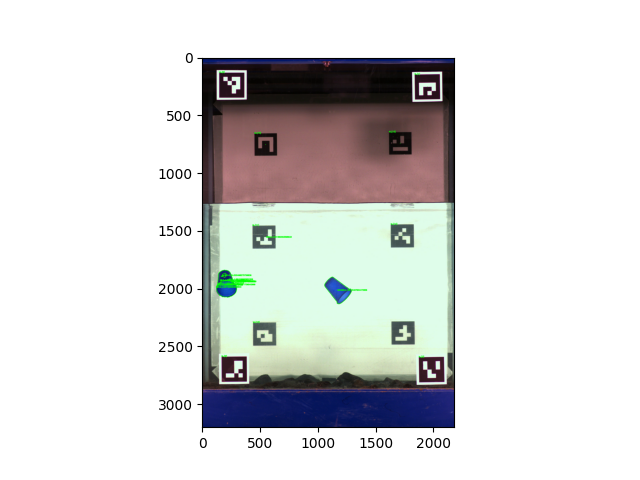

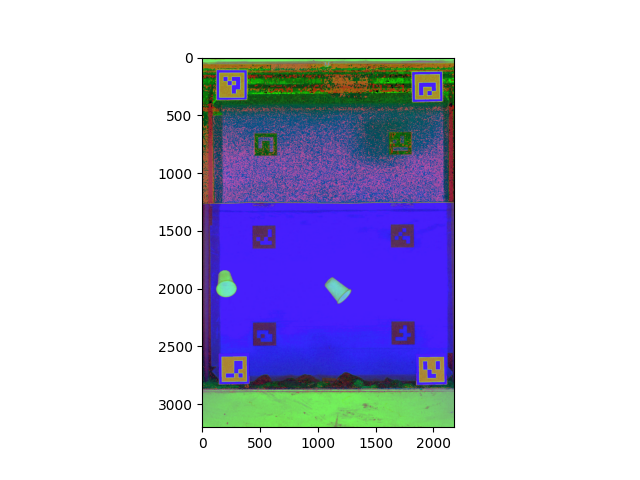

In [32]:
plt.figure()
plt.imshow(frame_display[:, :, ::-1])  # Display the annotated RGB frame
plt.figure()
plt.imshow(frame_HSV)  # Display the HSV frame

# 4. Run segmentation routine 

Pre-process the video by setting the starting frame, rotating if necessary and copying it for display

In [12]:
# Start the process time
startP = time.process_time()

# Initialize results list
Results = []

# Set video frame position
cap.set(cv2.CAP_PROP_POS_FRAMES, starting_frame_use)  # Set the video position to the starting frame defined in Settings (index base 0)
ret, frame = cap.read()  # Read the frame at the specified position

# Rotate the frame if necessary
if rotate:
    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)

# Prepare frame for display and processing
frame_display = frame.copy()  # Copy the frame for display
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert the frame to grayscale

Checks if a frame includes a blue object, if this is not the case for 30 consequetive frames, it skips 5 frames and re-analyzes. If a blue object is detected, it's contour and area is drawn. 

In [13]:
# Initialize object detection flag
ObjectDetected = False

# Start the main loop
while True:
    ObjectDetected = False  # Reset object detection flag
    start = time.process_time()  # Start the process time for the current frame
    surfaced = 0  # Initialize surfaced variable
    ret, frame = cap.read()  # Read the next frame from the video

    if ret:
        # Rotate the frame if necessary
        if rotate:
            frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)

        # Prepare frame for display and processing
        frame_display = frame.copy()  # Copy the frame for display
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert the frame to grayscale
        frame_HSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)  # Convert the frame to HSV color space

        # Detect and annotate ARUCO markers
        PlotCalibration(frame_GRAY, frame_display)

        # Color subtraction: blue
        fgMask = cv2.inRange(frame_HSV, np.array(HSV_range[0]), np.array(HSV_range[1]))  # Create a mask for blue color
        fgMask = cv2.blur(fgMask, (5, 5), 0)  # Blur the mask to reduce noise
        fgMask = cv2.bitwise_and(fgMask, fgMask, mask=AOI)  # Apply the AOI mask to the color mask

        # Detect main blob
        contours_Background, _ = cv2.findContours(fgMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)  # Find contours in the mask

        if len(contours_Background) > 0:
            for i, contour in enumerate(contours_Background):
                ((x, y), radius) = cv2.minEnclosingCircle(contour)  # Get the minimum enclosing circle for the contour

                # Check if the contour is within the AOI and has a valid radius
                if (AOI_1[0] < y) and (y < AOI_1[1]) and (AOI_1[2] < x) and (x < AOI_1[3]) and (radius > 50):
                    area = cv2.contourArea(contour)  # Calculate the area of the contour
                    if (area > 10000) & (area < 400000):
                        M = cv2.moments(contour)  # Calculate moments of the contour
                        center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))  # Calculate the center of the contour
                        ObjectDetected = True  # Set object detection flag to True
                        cv2.drawContours(frame_display, contour, -1, (0, 255, 0), 6)  # Draw the contour on the display frame
                        cv2.circle(frame_display, center, 5, (0, 255, 0), 2)  # Draw the center of the contour

        if not ObjectDetected:
            center = [np.nan, np.nan]  # Set center to NaN if no object is detected

        # Display frame information
        cv2.putText(
            frame_display,
            r"Frame {:0}".format(cap.get(cv2.CAP_PROP_POS_FRAMES)),
            (30, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.5,
            (0, 255, 0),
            2,
            cv2.LINE_AA,
        )
        time_diff = time.process_time() - start
        fps_actual = 1 / time_diff if time_diff > 0 else float("inf")
        cv2.putText(
            frame_display,
            r"fps {:0.2f}".format(fps_actual),
            (30, 70),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.5,
            (0, 255, 0),
            2,
            cv2.LINE_AA,
        )

        # Resize and display the frame
        frame_display = imutils.resize(frame_display, width=500)
        cv2.imshow("Frame", frame_display)
        if cv2.waitKey(10) & 0xFF == ord("q"):
            break

        # Append results
        Results.append([FrameIDSync, center[0], center[1]])

        # Skip frames if no particle is detected
        MemoryDetection.append(ObjectDetected)
        if (not any(MemoryDetection)) & (len(MemoryDetection) == 30):
            print(f"skipping {DTskip} frames")
            FrameIDSync += DTskip
            cap.set(cv2.CAP_PROP_POS_FRAMES, FrameIDSync)
        else:
            FrameIDSync = cap.get(cv2.CAP_PROP_POS_FRAMES)

        # Break the loop if the end of the video is reached
        if FrameIDSync >= frame_count:
            break

# Clean up and print results
cv2.destroyAllWindows()
Results = pd.DataFrame(Results, columns=["FrameIDSync", "centre_x", "centre_y"])
print("Processing time: ", time.process_time() - startP)

skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
skipping 5 frames
Processing time:  276.640625


Results are saved as a csv file to a defined directory

In [14]:
# Extract the name of the video file without extension
nameexp = pathVideo.split("\\")[-1].split(".")[0]

# Create the output directory if it does not exist
outputpath = os.path.join(dir_output, nameexp)
if not os.path.exists(outputpath):
    os.makedirs(outputpath)

# Save the results to a CSV file in the output directory
Results.to_csv(os.path.join(outputpath, nameexp + "_results.txt"))